In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

import collections
from copy import deepcopy


import warnings

warnings.filterwarnings("ignore")

In [11]:
def getDataframe(file_name: str) -> pd.DataFrame:

    return pd.read_csv(os.path.join(os.getcwd(), "data", "input", file_name), sep="\t")


# save dataframe to file


def saveDataframe(df: pd.DataFrame, file_name: str) -> None:
    df.to_csv(
        os.path.join(os.getcwd(), "data", "output", file_name), sep="\t", index=False
    )


def readFestaFile(file_name: str) -> dict:

    file_name_path = os.path.join(os.getcwd(), "data", "input", file_name)

    sequences = {}
    defline = None

    with open(file_name_path, "r") as file:
        for line in file:
            if line.startswith(">"):
                defline = line.strip().replace(">", "")
                sequences[defline] = ""
            else:
                if defline:
                    sequences[defline] += line.strip()

    return sequences


def setDataframeToDict(df: pd.DataFrame, key_column: str, value_column: str) -> dict:
    key_column_dict = collections.defaultdict(set)

    for index, row in df.iterrows():
        key_column_dict[row[key_column]].add(row[value_column])

    return dict(key_column_dict)


def getDataframeSize(df: pd.DataFrame) -> list:
    return [df.shape[0], df.shape[1]]


def dropDuplicate(df: pd.DataFrame) -> pd.DataFrame:
    df.drop_duplicates()
    return df


# print dictionary keys
def printDictKeys(dictionary: dict) -> None:
    for key in dictionary.keys():
        print(key)


def setDictToDataframe(dictionary: dict) -> pd.DataFrame:
    return pd.DataFrame(list(dictionary.items()), columns=["ProteinName", "Sequence"])

In [12]:
tool_A_df = getDataframe("tool_A_results.tsv")
tool_B_df = getDataframe("tool_B_results.tsv")

festa = readFestaFile("uniprot_sprot_2021-01-04_HUMAN.fasta")

print("TOOL-A DataFrame size:", getDataframeSize(tool_A_df))
print("TOOL-B DataFrame size:", getDataframeSize(tool_B_df))
print("FESTA Protein Sequences size:", len(festa))

print()

print("TOOL-A DataFrame columns:", tool_A_df.columns)
print("TOOL-B DataFrame columns:", tool_B_df.columns)

print()

print("TOOL-A DataFrame duplicates:", tool_A_df.duplicated().sum())
print("TOOL-B DataFrame duplicates:", tool_B_df.duplicated().sum())


print()

tool_A_df_copy = deepcopy(tool_A_df)
tool_A_df_copy.drop(columns=["index"], inplace=True)

print(
    "TOOL-A DataFrame duplicates before dropping the index column:",
    tool_A_df.duplicated().sum(),
)
print(
    "TOOL-A DataFrame duplicates after dropping the index column:",
    tool_A_df_copy.duplicated().sum(),
)

print()

tool_B_df_copy = deepcopy(tool_B_df)
tool_B_df_copy.drop(columns=["Sequence"], inplace=True)

print(
    "TOOL-B DataFrame duplicates before dropping the sequence column:",
    tool_B_df.duplicated().sum(),
)
print(
    "TOOL-B DataFrame duplicates after dropping the sequence column:",
    tool_B_df_copy.duplicated().sum(),
)

print()

tool_A_proteinName = tool_A_df["ProteinName"].tolist()
tool_B_proteinName = tool_B_df["ProteinName"].tolist()

print("TOOL-A ProteinName before removing duplicates:", len(tool_A_proteinName))
print("TOOL-B ProteinName before removing duplicates:", len(tool_B_proteinName))

print()

tool_A_proteinName = list(set(tool_A_proteinName))
tool_B_proteinName = list(set(tool_B_proteinName))


print("TOOL-A ProteinName list after removing the duplicates", len(tool_A_proteinName))
print("TOOL-B ProteinName list after removing duplicates", len(tool_B_proteinName))

TOOL-A DataFrame size: [91419, 3]
TOOL-B DataFrame size: [82732, 2]
FESTA Protein Sequences size: 20394

TOOL-A DataFrame columns: Index(['index', 'ProteinName', 'StrippedSequence'], dtype='object')
TOOL-B DataFrame columns: Index(['ProteinName', 'Sequence'], dtype='object')

TOOL-A DataFrame duplicates: 0
TOOL-B DataFrame duplicates: 66337

TOOL-A DataFrame duplicates before dropping the index column: 0
TOOL-A DataFrame duplicates after dropping the index column: 38261

TOOL-B DataFrame duplicates before dropping the sequence column: 66337
TOOL-B DataFrame duplicates after dropping the sequence column: 80170

TOOL-A ProteinName before removing duplicates: 91419
TOOL-B ProteinName before removing duplicates: 82732

TOOL-A ProteinName list after removing the duplicates 4936
TOOL-B ProteinName list after removing duplicates 2562


In [13]:
tool_A_dict = setDataframeToDict(tool_A_df, "ProteinName", "StrippedSequence")
tool_B_dict = setDataframeToDict(tool_B_df, "ProteinName", "Sequence")


def semicolonHandlingHelper(dictionary: dict) -> dict:
    split_dict = {}
    for key, value in dictionary.items():
        protein_names = key.split(";")
        for protein_name in protein_names:
            split_dict[protein_name] = value
    return split_dict


tool_A_dict = semicolonHandlingHelper(tool_A_dict)

saveDataframe(setDictToDataframe(tool_A_dict), "tool_A_results.tsv")

print("TOOL-A ProteinName dictionary size:", len(tool_A_dict))

TOOL-A ProteinName dictionary size: 4984


### Extracting Name Process


In [14]:
import re

tool_A_keys = list(tool_A_dict.keys())

tool_B_keys = list(tool_B_dict.keys())

festa_keys = list(festa.keys())


def extractProteinNamesFromToolB(str_list: list) -> list:
    protein_names = []
    # Regular expression to find the protein name pattern
    # sp|P62258|1433E_HUMAN -> 1433E_HUMAN
    pattern = re.compile(r"\|(\w+_\w+)\b")

    for s in str_list:
        match = pattern.search(s)
        if match:
            protein_names.append(match.group(1))
        else:
            protein_names.append(None)

    return protein_names


def extractUniProtFromToolB(str_list: list) -> list:
    protein_names = []
    # Regular expression to find the protein name pattern
    # sp|P62258|1433E_HUMAN -> P62258
    pattern = re.compile(r"\|(\w+)\b")

    for s in str_list:
        match = pattern.search(s)
        if match:
            protein_names.append(match.group(1))
        else:
            protein_names.append(None)

    return protein_names


def extractUniProtFromFesta(str_list: list) -> list:
    protein_names = []
    # Regular expression to find the protein name pattern
    # sp|P62258|1433E_HUMAN -> P62258
    pattern = re.compile(r"\|(\w+)\b")

    for s in str_list:
        match = pattern.search(s)
        if match:
            protein_names.append(match.group(1))
        else:
            protein_names.append(None)

    return protein_names


def extractProteinNamesFromFesta(str_list: list) -> list:
    protein_names = []
    pattern = re.compile(r"\|(\w+_\w+)\s")

    for s in str_list:
        match = pattern.search(s)
        if match:
            protein_names.append(match.group(1))
        else:
            protein_names.append(None)

    return protein_names


# --DEBBUGING--

# festa id and protein name dictionary
festa_id_and_protein_name_dict = dict(
    zip(extractUniProtFromFesta(festa_keys), extractProteinNamesFromFesta(festa_keys))
)

print(
    {
        k: festa_id_and_protein_name_dict[k]
        for k in list(festa_id_and_protein_name_dict)[:1]
    }
)

# festa protein name and protein sequence dictionary
festa_protein_name_and_protein_seq_dict = dict(
    zip(extractProteinNamesFromFesta(festa_keys), festa.values())
)

print(
    {
        k: festa_protein_name_and_protein_seq_dict[k]
        for k in list(festa_protein_name_and_protein_seq_dict)[:1]
    }
)

# festa id and protein sequence dictionary
festa_id_and_protein_seq_dict = dict(
    zip(extractUniProtFromFesta(festa_keys), festa.values())
)
print(
    {
        k: festa_id_and_protein_seq_dict[k]
        for k in list(festa_id_and_protein_seq_dict)[:1]
    }
)

# tool A protein name and protein sequence dictionary
tool_a_protein_name_and_protein_seq_dict = dict(zip(tool_A_keys, tool_A_dict.values()))
print(
    {
        k: tool_a_protein_name_and_protein_seq_dict[k]
        for k in list(tool_a_protein_name_and_protein_seq_dict)[:1]
    }
)

# tool B id and protein name dictionary
tool_b_id_and_protein_name_dict = dict(
    zip(extractUniProtFromToolB(tool_B_keys), extractProteinNamesFromToolB(tool_B_keys))
)
print(
    {
        k: tool_b_id_and_protein_name_dict[k]
        for k in list(tool_b_id_and_protein_name_dict)[:1]
    }
)

# tool B id and protein sequence dictionary
tool_b_id_and_protein_seq_dict = dict(
    zip(extractUniProtFromToolB(tool_B_keys), tool_B_dict.values())
)
print(
    {
        k: tool_b_id_and_protein_seq_dict[k]
        for k in list(tool_b_id_and_protein_seq_dict)[:1]
    }
)

# tool B protein name and protein sequence dictionary
tool_b_protein_name_and_protein_seq_dict = dict(
    zip(extractProteinNamesFromToolB(tool_B_keys), tool_B_dict.values())
)
print(
    {
        k: tool_b_protein_name_and_protein_seq_dict[k]
        for k in list(tool_b_protein_name_and_protein_seq_dict)[:1]
    }
)

{'P31946': '1433B_HUMAN'}
{'1433B_HUMAN': 'MTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLLSVAYKNVVGARRSSWRVISSIEQKTERNEKKQQMGKEYREKIEAELQDICNDVLELLDKYLIPNATQPESKVFYLKMKGDYFRYLSEVASGDNKQTTVSNSQQAYQEAFEISKKEMQPTHPIRLGLALNFSVFYYEILNSPEKACSLAKTAFDEAIAELDTLNEESYKDSTLIMQLLRDNLTLWTSENQGDEGDAGEGEN'}
{'P31946': 'MTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLLSVAYKNVVGARRSSWRVISSIEQKTERNEKKQQMGKEYREKIEAELQDICNDVLELLDKYLIPNATQPESKVFYLKMKGDYFRYLSEVASGDNKQTTVSNSQQAYQEAFEISKKEMQPTHPIRLGLALNFSVFYYEILNSPEKACSLAKTAFDEAIAELDTLNEESYKDSTLIMQLLRDNLTLWTSENQGDEGDAGEGEN'}
{'SRC8_HUMAN': {'QDSAAVGFDYK', 'RENVFQEHQTLK', 'STFEDVTQVSSAYQK', 'GPVSGTEPEPVYSME', 'GPVSGTEPEPVYSMEAADYR', 'TVPVEAVTSK', 'YRGPVSGTEPEPVYSMEAADYR', 'SIAQDDAGADDWETDPDFVNDVSEKEQR', 'DWETDPDFVNDVSEKEQR', 'PVEAVTSK', 'SAVGFDYQGK', 'NASTFEDVTQVSSAYQK', 'TVPVEAV', 'TQTPPVSPAPQPTEERLPSSPVYEDAA', 'ENVFQEHQTLK', 'TQTPPVSPAPQPTEER', 'ASAGHAVSIAQDDAGADDWETDPDFVNDVSEK', 'FGVQMDR', 'FGVEQDRMDK', 'LRENVFQEHQ', 'TQTPPVSPAPQPTEERLPSSPVYEDAASFK', 'LPSSPVYEDA

In [15]:
# Intersection of the festa and tool A protein names
intersection_festa_tool_a_protein_names = set(
    festa_protein_name_and_protein_seq_dict.keys()
).intersection(tool_a_protein_name_and_protein_seq_dict.keys())

print(
    "Intersection of the festa and tool A protein names:",
    len(intersection_festa_tool_a_protein_names),
)

# Intersection of the festa and tool B protein names
intersection_festa_tool_b_protein_names = set(
    festa_protein_name_and_protein_seq_dict.keys()
).intersection(tool_b_protein_name_and_protein_seq_dict.keys())
print(
    "Intersection of the festa and tool B protein names:",
    len(intersection_festa_tool_b_protein_names),
)

intersection_festa_tool_b_ids = set(festa_id_and_protein_seq_dict.keys()).intersection(
    tool_b_id_and_protein_seq_dict.keys()
)
print("Intersection of the festa and tool B ids:", len(intersection_festa_tool_b_ids))

Intersection of the festa and tool A protein names: 4960
Intersection of the festa and tool B protein names: 2491
Intersection of the festa and tool B ids: 2496


In [16]:
# Get dictionary where intersection of festa and tool A protein names
festa_tool_a_protein_name_and_protein_seq_dict = {
    k: festa_protein_name_and_protein_seq_dict[k]
    for k in intersection_festa_tool_a_protein_names
}

# Get dictionary where intersection of festa and tool B protein names

festa_tool_b_protein_name_and_protein_seq_dict = {
    k: festa_protein_name_and_protein_seq_dict[k]
    for k in intersection_festa_tool_b_protein_names
}

print(len(festa_tool_a_protein_name_and_protein_seq_dict))
print(len(festa_tool_b_protein_name_and_protein_seq_dict))

4960
2491


In [17]:
def getSequenceLengths(sequences: dict) -> dict:
    lengths = {}
    for defline, seq in sequences.items():
        lengths[defline] = len(seq)
    return lengths

In [18]:
# #--DEBBUGING--

# temp_str = 'NNQVLGIGSGSTIVHAVQR'+'QENLNLVCIPTSFQAR'+'AGPVVTDNGNFILDWK'+'FGGVVELR'+'FIVIADFR'+'AAVENHVRNNQ'

# len(temp_str) -len('NNQ')


# input1 ='MQRPGPFSTLYGRVLAPLPGRAGGAASGGGGNSWDLPGSHVRLPGRAQSGTRGGAGNTST' + 'SCGDSNSICPAPSTMSKAEEAKKLAGRAAVENHVRNNQVLGIGSGSTIVHAVQRIAERVK' +'QENLNLVCIPTSFQARQLILQYGLTLSDLDRHPEIDLAIDGADEVDADLNLIKGGGGCLT' +'QEKIVAGYASRFIVIADFRKDSKNLGDQWHKGIPIEVIPMAYVPVSRAVSQKFGGVVELR'+'MAVNKAGPVVTDNGNFILDWKFDRVHKWSEVNTAIKMIPGVVDTGLFINMAERVYFGMQD'+'GSVNMREKPFC'
# input2 = {'DECOY': {'NNQVLGIGSGSTIVHAVQR', 'QENLNLVCIPTSFQAR', 'AGPVVTDNGNFILDWK', 'FGGVVELR', 'FIVIADFR', 'AAVENHVRNNQ'}}


def calculateProteinCoverage(protein_seq: str, peptides: set) -> float:
    covered = set()
    for peptide in peptides:
        start = protein_seq.find(peptide)
        if start != -1:
            covered.update(range(start, start + len(peptide)))
    coverage = len(covered) / len(protein_seq)
    return coverage


# # Example usage for a single protein
# protein_id = 'P49247'
# protein_sequence = i
# peptides = {'NNQVLGIGSGSTIVHAVQR', 'QENLNLVCIPTSFQAR', 'AGPVVTDNGNFILDWK', 'FGGVVELR', 'FIVIADFR', 'AAVENHVRNNQ'}
# coverage = calculate_coverage(protein_sequence, peptides)
# print(f"Coverage for {protein_id}: {coverage:.2%}")


def isSimplifiedSemiTryptic(protein_sequence: str, peptide_sequences: set) -> list:
    results = []
    for peptide_sequence in peptide_sequences:
        index = protein_sequence.find(peptide_sequence)
        if index == -1:
            results.append(False)  # Peptide not found in protein, not semi-tryptic
            continue

        before = (
            protein_sequence[index - 1] if index > 0 else "R"
        )  # K or R at start assumed
        after = (
            protein_sequence[index + len(peptide_sequence)]
            if index + len(peptide_sequence) < len(protein_sequence)
            else ""
        )

        peptide_ends = peptide_sequence[-1] in ["K", "R"]
        before_ends = before in ["K", "R"]

        if (peptide_ends and not before_ends) or (not peptide_ends and before_ends):
            results.append(True)
        else:
            results.append(False)

    return results


# # --DEBUGGING--

# def getKey(dictionary: dict, value: str) -> str:
#     for key, val in dictionary.items():
#         if val == value:
#             return key
#     return None

# def getValues(dictionary: dict, key: str) -> str:
#     if key not in dictionary:
#         return None
#     return dictionary[key]


# print(getValues(tool_B_dict, 'SLX4I_HUMAN'))

# print(getValues(festa_tool_a_protein_name_and_protein_seq_dict, 'SLX4I_HUMAN'))

In [20]:
# tool_A_dict to pd.DataFrame
tool_a_protein_name_and_protein_seq_df = setDictToDataframe(
    tool_a_protein_name_and_protein_seq_dict
)

festa_tool_a_protein_name_and_protein_seq_df = setDictToDataframe(
    festa_tool_a_protein_name_and_protein_seq_dict
)


tool_b_protein_name_and_protein_seq_df = setDictToDataframe(
    tool_b_protein_name_and_protein_seq_dict
)

festa_tool_b_protein_name_and_protein_seq_df = setDictToDataframe(
    festa_tool_b_protein_name_and_protein_seq_dict
)

# rename columns
tool_a_protein_name_and_protein_seq_df.rename(
    columns={"ProteinName": "ProteinName", "Sequence": "StrippedSequence"}, inplace=True
)

tool_b_protein_name_and_protein_seq_df.rename(
    columns={"ProteinName": "ProteinName", "Sequence": "StrippedSequence"}, inplace=True
)


# merge df on ProteinName
main_tool_a_df = festa_tool_a_protein_name_and_protein_seq_df.merge(
    tool_a_protein_name_and_protein_seq_df, on="ProteinName", how="inner"
)

main_tool_b_df = festa_tool_b_protein_name_and_protein_seq_df.merge(
    tool_b_protein_name_and_protein_seq_df, on="ProteinName", how="inner"
)
# main_df['isSimplifiedSemiTryptic'] = main_df.apply(lambda x: isSimplifiedSemiTryptic(x['Sequence'], x['StrippedSequence']), axis=1)


main_tool_a_df["isSimplifiedSemiTryptic"] = main_tool_a_df.apply(
    lambda x: isSimplifiedSemiTryptic(x["Sequence"], x["StrippedSequence"]), axis=1
)

main_tool_b_df["isSimplifiedSemiTryptic"] = main_tool_b_df.apply(
    lambda x: isSimplifiedSemiTryptic(x["Sequence"], x["StrippedSequence"]), axis=1
)

main_tool_a_df["ProteinCoverage"] = main_tool_a_df.apply(
    lambda x: calculateProteinCoverage(x["Sequence"], x["StrippedSequence"]), axis=1
)

main_tool_b_df["ProteinCoverage"] = main_tool_b_df.apply(
    lambda x: calculateProteinCoverage(x["Sequence"], x["StrippedSequence"]), axis=1
)

In [44]:
main_tool_a_df

,ProteinName,Sequence,StrippedSequence,isSimplifiedSemiTryptic,ProteinCoverage,SemiTrypticCoverage
0,HNRPC_HUMAN,MASNVTNKTDPRSMNSRVFIGNLNTLVVKKSDVEAIFSKYGKIVGC...,"{QVLDINLAAEPK, GFAFVQYVNER, SDVEAIFSK, VDSLLEN...","[True, False, False, False, False, True, False...",0.258170,0.333333
1,AGM1_HUMAN,MDLGAITKYSALHAKPNGLILQYGTAGFRTKAEHLDHVMFRMGLLA...,"{QAVTPPGLQEAINDLVKK, AFVRPSGTEDVVR, LVDPLGEM, ...","[False, False, True, True, False, False, False...",0.265683,0.294118
2,DUS23_HUMAN,MGVQPPNFSWVLPGRLAGLALPRLPAHYQFLLDLGVRHLVSLTERG...,"{LAGLALPR, FVQIVDEANAR, LRIPDFCPPAPDQIDR, LRPG...","[False, False, False, False, False, False, Fal...",0.966667,0.083333
3,UBIP1_HUMAN,MAWVLKMDEVIESGLVHDFDASLSGIGQELGAGAYSMSDVLALPIF...,"{EDLVQICGAADGIR, LTIYVCR, LLDLDIPMSVGIIDTR}","[False, False, False]",0.068519,0.000000
4,TFIP8_HUMAN,MHSEAEESKEVATDVFNSKNLAVQAQKKILGKMVSKSIATTLIDDT...,{SIATTLIDDTSSEVLDELYR},[False],0.101010,0.000000
...,...,...,...,...,...,...
4955,GGA1_HUMAN,MEPAMEPETLEARINRATNPLNKELDWASINGFCEQLNEDFEGPPL...,"{LLTEMVMSHSQGGAAAGSSEDLMK, NVIFEDEEK, LPDDTTFP...","[False, False, False, False, False, True, True...",0.197183,0.300000
4956,TCPR2_HUMAN,MASISEPVTFREFCPLYYLLNAIPTKIQKGFRSIVVYLTALDTNGD...,"{DGLEMSGCSER, RFDVTGIHK}","[False, False]",0.014174,0.000000
4957,JUPI1_HUMAN,MTTTTTFKGVDPNSRNSSRVLRPPGGGSNFSLGFDEPTEQPVRKNK...,"{SLGFDEPTEQPVR, GEGDIHENVDTDLPGSLGQSEEKPVPAAPV...","[True, False, True, True, True, True, True, Tr...",0.655844,0.833333
4958,BUB3_HUMAN,MTGSNEFKLNQPPEDGISSVKFSPNTSQFLLVSSWDTSVRLYDVPA...,"{MHDLNTDQENLVGTHDAPIR, ENNIEQI, VTGSWDQTVK, VA...","[False, True, True, False, False, False, True,...",0.286585,0.333333


In [45]:
main_tool_b_df

,ProteinName,Sequence,StrippedSequence,isSimplifiedSemiTryptic,ProteinCoverage,SemiTrypticCoverage
0,HNRPC_HUMAN,MASNVTNKTDPRSMNSRVFIGNLNTLVVKKSDVEAIFSKYGKIVGC...,"{RVPPPPPIAR, GFAFVQYVNER}","[True, False]",0.068627,0.500000
1,HDGR2_HUMAN,MPHAFKPGDLVFAKMKGYPHWPARIDDIADGAVKPPPNKYPIFFFG...,"{LAGEELAGEEAPQEK, PHAFKPGDLVFAK}","[False, True]",0.041729,0.500000
2,PYGB_HUMAN,MAKPLTDSEKRKQISVRGLAGLGDVAEVRKSFNRHLHFTLVKDRNV...,"{AQVDQLYR, HLDHVAALFPGDVDR, VEDVEALDR, RVEDVEA...","[True, False, False, True, False, False, False...",0.260973,0.260870
3,CING_HUMAN,MAEPRGPVDHGVQIRFITEPVSGAEMGTLRRGGRRPAKDARASTYG...,"{SSDLELPENPYSQVK, LEPSQVGLER}","[True, False]",0.020886,0.500000
4,AGM1_HUMAN,MDLGAITKYSALHAKPNGLILQYGTAGFRTKAEHLDHVMFRMGLLA...,"{AFVRPSGTEDVVR, YLEEVMK, AEHLDHVMFR, ATIEGYYQK...","[False, False, False, False, False, False, Fal...",0.160517,0.000000
...,...,...,...,...,...,...
2486,JUPI1_HUMAN,MTTTTTFKGVDPNSRNSSRVLRPPGGGSNFSLGFDEPTEQPVRKNK...,"{GQSEEKPVPAAPVPSPVAPAPVPSR, VLRPPGGGSNFSLGFDEP...","[True, False, True, True, False, True, True, T...",0.597403,0.727273
2487,DEOC_HUMAN,MSAHNRGTELDLSWISKIQVNHPAVLRRAEQIQARRTVKKEWQAAW...,"{DSLAWLSLVK, GITTAAVCVYPAR, AAGCNIPVASVAAGFPAG...","[False, False, False, False, False, False, False]",0.305031,0.000000
2488,BUB3_HUMAN,MTGSNEFKLNQPPEDGISSVKFSPNTSQFLLVSSWDTSVRLYDVPA...,"{RVLVWDLR, MHDLNTDQENLVGTHDAPIR, LNQPPEDGISSVK...","[False, False, False, False, False, False, Fal...",0.393293,0.090909
2489,GBF1_HUMAN,MVDKNIYIIQGEINIVVGAIKRNARWSTHTPLDEERDPLLHSFGHL...,"{SGCSDLEEAVDSGADK, VLFPLLTK, TPGHPPPPEIPSELGAC...","[False, False, False, False]",0.033351,0.000000


In [28]:
# isSimplifiedSemTrytic [False, True, False, True, False, False, False, True, True, True, False, False, True, True, True, False, False, False, True, False, False, True, False, True, False]
# get me a function that  len(only True) /len(isSimplifiedSemTrytic)


def calculateSemiTrypticCoverage(isSimplifiedSemiTryptic: list) -> float:
    return isSimplifiedSemiTryptic.count(True) / len(isSimplifiedSemiTryptic)


main_tool_a_df["SemiTrypticCoverage"] = main_tool_a_df["isSimplifiedSemiTryptic"].apply(
    calculateSemiTrypticCoverage
)

main_tool_b_df["SemiTrypticCoverage"] = main_tool_b_df["isSimplifiedSemiTryptic"].apply(
    calculateSemiTrypticCoverage
)
# first

In [31]:
# mean of the protein coverage
print(
    "Mean of the protein coverage for tool A:", main_tool_a_df["ProteinCoverage"].mean()
)
print(
    "Mean of the protein coverage for tool B:", main_tool_b_df["ProteinCoverage"].mean()
)

print()
# mean of the semi-tryptic coverage
print(
    "Mean of the semi-tryptic coverage for tool A:",
    main_tool_a_df["SemiTrypticCoverage"].mean(),
)
print(
    "Mean of the semi-tryptic coverage for tool B:",
    main_tool_b_df["SemiTrypticCoverage"].mean(),
)

Mean of the protein coverage for tool A: 0.21165873787663475
Mean of the protein coverage for tool B: 0.15569689715568766

Mean of the semi-tryptic coverage for tool A: 0.22875735554184481
Mean of the semi-tryptic coverage for tool B: 0.13782143503099056


In [41]:
def getProteinCoverageStats(coverage: dict) -> dict:
    values = list(coverage.values())
    return {
        "min": min(values),
        "max": max(values),
        "mean": np.mean(values),
        "median": np.median(values),
        "std": np.std(values),
    }


def plotProteinCoverage(coverage: dict) -> None:
    plt.hist(list(coverage.values()), bins=20)
    plt.xlabel("Protein Coverage")
    plt.ylabel("Frequency")
    plt.title("Protein Coverage Distribution")
    plt.show()


# df to dictionary key protein name value protein coverage
protein_name_protein_coverage_tool_a_dict = dict(
    zip(main_tool_a_df["ProteinName"], main_tool_a_df["ProteinCoverage"])
)

protein_name_protein_coverage_tool_b_dict = dict(
    zip(main_tool_b_df["ProteinName"], main_tool_b_df["ProteinCoverage"])
)

print(getProteinCoverageStats(protein_name_protein_coverage_tool_a_dict))

print(getProteinCoverageStats(protein_name_protein_coverage_tool_b_dict))

{'min': 0.0, 'max': 0.9666666666666667, 'mean': 0.21165873787663475, 'median': 0.15834654736285725, 'std': 0.18216280772405555}
{'min': 0.0, 'max': 0.8048780487804879, 'mean': 0.15569689715568766, 'median': 0.11818181818181818, 'std': 0.13250813134105374}


In [25]:
saveDataframe(main_tool_a_df, "main_tool_a_results.tsv")
saveDataframe(main_tool_b_df, "main_tool_b_results.tsv")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


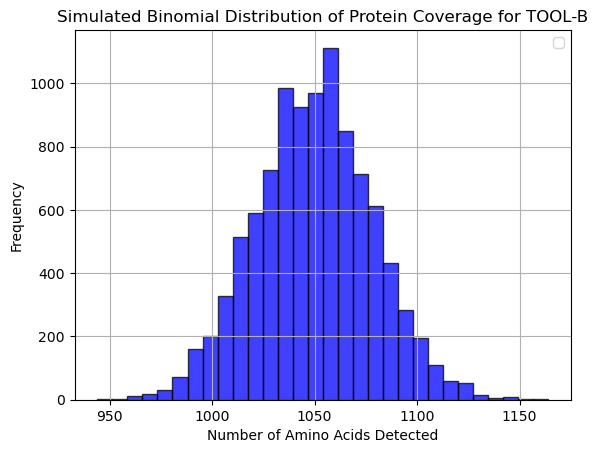

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n = 4960  # Total number of amino acids in the protein
p = 0.21165873787663475  # Probability of detecting each amino acid, estimated from observed data

# Generate a binomial distribution
simulated_coverage = np.random.binomial(n, p, size=10000)

# Plotting the distribution
plt.hist(simulated_coverage, bins=30, alpha=0.75, color="blue", edgecolor="black")
plt.title("Simulated Binomial Distribution of Protein Coverage for TOOL-A")
plt.xlabel("Number of Amino Acids Detected")
plt.ylabel("Frequency")
# plt.axvline(x=75, color='red', linestyle='--', label='Observed Coverage (75)')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


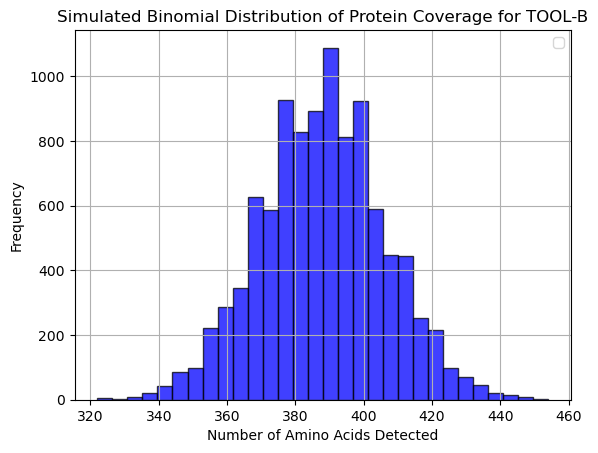

In [39]:
# Parameters
n = 2491  # Total number of amino acids in the protein
p = 0.15569689715568766  # Probability of detecting each amino acid, estimated from observed data

# Generate a binomial distribution
simulated_coverage = np.random.binomial(n, p, size=10000)

# Plotting the distribution
plt.hist(simulated_coverage, bins=30, alpha=0.75, color="blue", edgecolor="black")
plt.title("Simulated Binomial Distribution of Protein Coverage for TOOL-B")
plt.xlabel("Number of Amino Acids Detected")
plt.ylabel("Frequency")
# plt.axvline(x=75, color='red', linestyle='--', label='Observed Coverage (75)')
plt.legend()
plt.grid(True)
plt.show()

결과 분석 결과, TOOL-A는 TOOL-B보다 뛰어난 성능을 보였습니다. TOOL-A의 최대 Protein Coverage는 97%로,     
TOOL-B의 최대 Protein Coverage 80%보다 월등히 높았습니다. 또한, TOOL-A와 TOOL-B의 평균 Protein Coverage는 각각 21%와 15%로,   
TOOL-A가 더 높은 평균 값을 기록했습니다. Simplified Semi Tryptic 검출 능력에 있어서도 TOOL-A는 TOOL-B보다 우수한 결과를 나타내었는데,    
TOOL-A는 평균적으로 22%, TOOL-B는 13%의 펩타이드가 Simplified Semi Tryptic임을 확인할 수 있었습니다.
